# Estimate the extent of the mudslide from Jagersfontain's tailings dam's collapse in Septembre 2022

## Part 1: Import data
The images where selected and exported from Google Earth Engine. 

In [1]:
import os 
import rasterio
from rasterio import plot
from rasterio.plot import show
import matplotlib.pyplot as plt
# Two different plotting libraries: plot for rasterio and plt for matplotlib

In [3]:
# Check the availables files in folder
bandPath = "sentinel2/"
bandNames = os.listdir(bandPath)
bandNames

['.DS_Store',
 'july13',
 'september16',
 'sentinel2-allbands-before.tif',
 'sentinel2-allbands-after.tif']

In [5]:
# Load all bands
#band1 = rasterio.open(bandPath + "sentinel2-b1.tif") #ultra blue
band2 = rasterio.open(bandPath + "july13/sentinel2-b2.tif") #blue
band3 = rasterio.open(bandPath + "july13/sentinel2-b3.tif") #green
band4 = rasterio.open(bandPath + "july13/sentinel2-b4.tif") #red
band5 = rasterio.open(bandPath + "july13/sentinel2-b5.tif") #nir
band6 = rasterio.open(bandPath + "july13/sentinel2-b6.tif") #nir
"""band7 = rasterio.open(bandPath + "sentinel2-b7.tif") #nir
band8 = rasterio.open(bandPath + "sentinel2-b8.tif") #nir
band8a = rasterio.open(bandPath + "sentinel2-b8a.tif") #nir
band9 = rasterio.open(bandPath + "sentinel2-b9.tif") #swir
band10 = rasterio.open(bandPath + "sentinel2-b10.tif") #swir
band11 = rasterio.open(bandPath + "sentinel2-b11.tif") #swir
band12 = rasterio.open(bandPath + "sentinel2-b12.tif") #swir"""

allbandsAfter = rasterio.open(bandPath + "sentinel2-allbands-after.tif")
allbandsBefore = rasterio.open(bandPath + "sentinel2-allbands-before.tif")

## Part 2: Data exploration

In [7]:
# Pritn raster informations and bands number
print("Raster Sentinel2 from after the collapse has %d bands, %d columns, %d rows and its CRS is %s." % (allbandsAfter.count, allbandsAfter.width, allbandsAfter.height, allbandsAfter.crs))
allbandsAfter.descriptions

Raster Sentinel2 from after the collapse has 12 bands, 6467 columns, 4240 rows and its CRS is EPSG:4326.


('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12')

In [8]:
#Show metadata
allbandsAfter.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 6467,
 'height': 4240,
 'count': 12,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.983152841195215e-05, 0.0, 25.160283972204795,
        0.0, -8.983152841195215e-05, -29.441115627147962)}

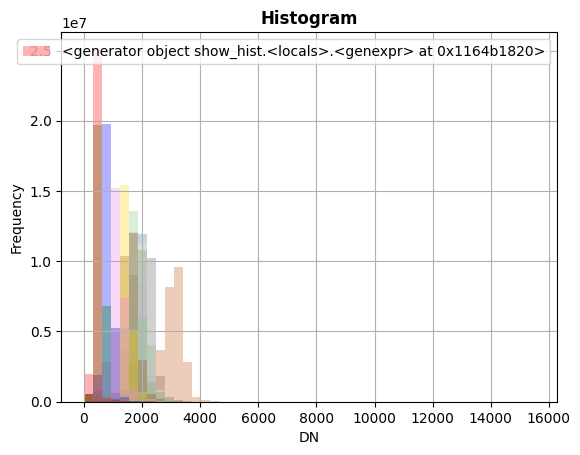

In [16]:
# Plot raster histogram with rasterio.plot
plot.show_hist(allbandsAfter, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram")

Blue, green and red bands channels from july 13th.


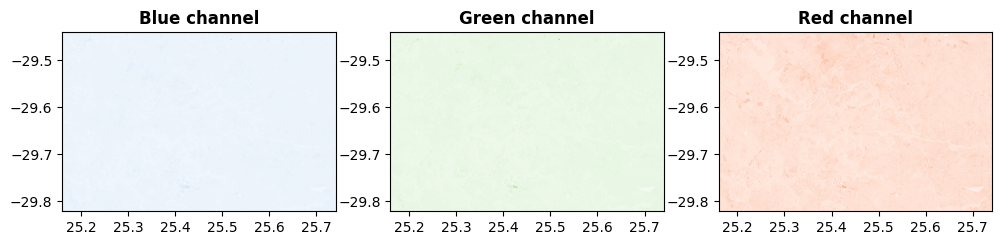

In [9]:
# Multiple band representation 
print("Blue, green and red bands channels from july 13th.")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
show((band2, 1), ax=ax1, cmap='Blues', title='Blue channel')
show((band3, 1), ax=ax2, cmap='Greens', title='Green channel')
show((band4, 1), ax=ax3, cmap='Reds', title='Red channel')
plt.show()

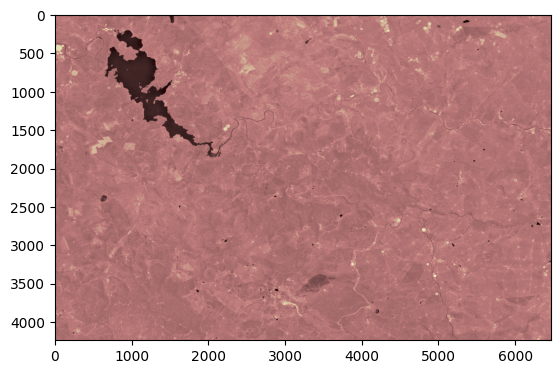

In [10]:
# Plot a single band, here band 6, using matplotlib's pyplot
plt.imshow(allbandsAfter.read(6), cmap='pink')

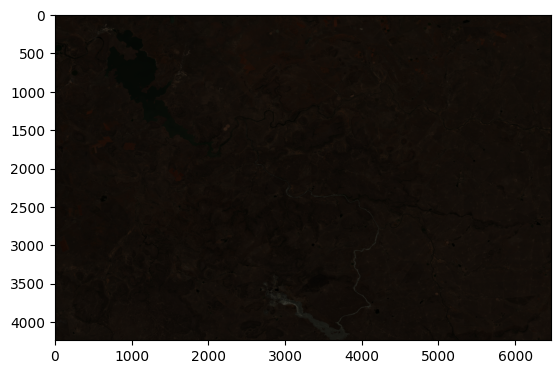

<AxesSubplot:>

In [11]:
# show sentinel image in rgb - the data needs to be sclae before as matplotlib deosn't go it automatically
# it is very dark -> how to lighten it?
import numpy as np

data = allbandsAfter.read([4,3,2])
arr = (data * (255 / np.max(data))).astype(np.uint8)
show(arr)

## Part 3: Algorithm

In [24]:
# stack all layer / this is not necessary if stacked image already exist

def stack_bands(files):
  img_fp = 'sentinel_bands.tif'
  # Read metadata of first file and assume all other bands are the same
  with rasterio.open(files[0]) as src0:
      meta = src0.meta

  # Update metadata to reflect the number of layers
  meta.update(count = len(files))

  # Read each layer and write it to stack
  with rasterio.open(img_fp, 'w', **meta) as dst:
      for id, layer in enumerate(files, start=1):
          with rasterio.open(layer) as srclassifer:
              dst.write_band(id, srclassifer.read(1))

  return img_fp

In [25]:
file_list = ["sentinel2-july13/sentinel2-b1.tif", 
"sentinel2-july13/sentinel2-b2.tif", 
"sentinel2-july13/sentinel2-b3.tif", 
"sentinel2-july13/sentinel2-b4.tif", 
"sentinel2-july13/sentinel2-b5.tif", 
"sentinel2-july13/sentinel2-b6.tif"]
stacked_bands = rasterio.open(stack_bands(file_list))

In [23]:
# Chose which image to use :before or after (just comment out the one you don't want)
# Those 2 images have 12 bands

#stacked_bands = allbandsAfter
stacked_bands = allbandsBefore

In [24]:
#Check the stacked shape -> create an empty array with same dimensions
print(stacked_bands.shape)
reshaped = np.empty((stacked_bands.height, stacked_bands.width, stacked_bands.count), stacked_bands.meta['dtype'])
print("New empty array has shape: " + str(reshaped.shape))

(4240, 6467)
New empty array has shape: (4240, 6467, 12)


In [25]:
# Loop through the raster's bands to fill the new empty array
for band in range(reshaped.shape[2]):
    reshaped[:,:,band] = stacked_bands.read(band+1)
reshaped.shape

(4240, 6467, 12)

In [26]:
# convet to 1d array
reshaped1d = reshaped[:,:,:12].reshape((reshaped.shape[0]*reshaped.shape[1],reshaped.shape[2]))
reshaped1d.shape

(27420080, 12)

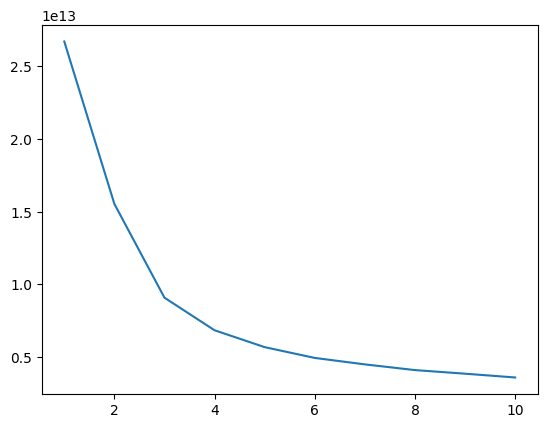

In [27]:
# Using the elbow method, try the Kmeans algorithm with 2 to 10 clusters

import seaborn as sns 
from sklearn import cluster

wcss = []

for i in range(1, 11):
    kmeans_cl = cluster.KMeans(n_clusters=i, init='k-means++', random_state=42, n_init='auto')
    kmeans_cl.fit(reshaped1d)
    wcss.append(kmeans_cl.inertia_)
    
ks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
sns.lineplot(x = ks, y = wcss);

In [28]:
# Fit algorithm with clusters = 4 - this kind of looks like the elbow + this cluster number makes sense

kmeans_cl = cluster.KMeans(n_clusters=i, init='k-means++', random_state=42, n_init='auto')
param = kmeans_cl.fit(reshaped1d)

## Part 4: Show clustering results


In [29]:
# reshape cluster results to be able to show it
img_cl = kmeans_cl.labels_
img_cl = img_cl.reshape(reshaped[:,:,0].shape)
img_cl.shape

(4240, 6467)

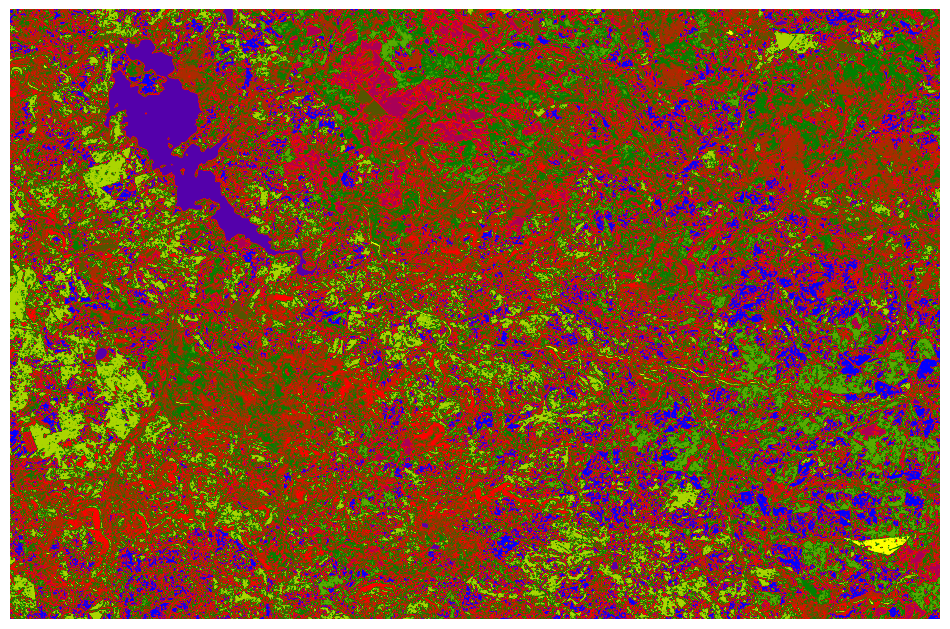

In [30]:
# Show clusters from image from September 16th
import matplotlib.colors as mc

cmap = mc.LinearSegmentedColormap.from_list('colors', ["blue","red","green","yellow"])
plt.figure(figsize=[12,12])
plt.imshow(img_cl, cmap=cmap)
plt.axis('off')
#plt.savefig("elhas_clustered.jpg", bbox_inches='tight')
plt.show()

## Next steps:

- update code and create functions that will allow to process multiple images
- compare the clusters from the image before and the image after the dam's collapse
- use supervised classification algortitm to get better results